## This notebook is an exploration of an Olympics dataset, "120 years of Olympic history: athletes and results". First, we'll take a peek at the data and see what ideas we can come up with for possible tasks. Then, we'll perform Data Cleaning, EDA, and finally, some modeling. 

In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# set the figure size for matplotlib plots 
plt.rcParams["figure.figsize"] = (12, 8)
        

In [4]:
df = pd.read_csv('120-years-of-olympic-history-athletes-and-results/athlete_events.csv')
df.shape

(271116, 15)

In [5]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


## **Initial questions/ thoughts about the data:**


General questions:
* what's the distribution of male to female athletes? has this changed over time?
* what about the distribution of athlete weights? how does this differ by sport?
    * which sports have the highest/ lowest weights?
* same as questions above, but with ages
* do younger athletes win more than older ones?
* what's the distribution of athlete age by country?
    * do some countries have older athletes?
    * how does this change over time for some specific countries?
* is there a "home country" advantage?
    * statistically significant difference in medals
    * how would we measure this? lots of confounding variables
    

Data Cleaning:
* how many missing values do we have in each column?
* how will we parse out country names - "Denmark/ Sweden" should be 1 for Denmark, 1 for Sweden

Modeling:
* can we predict who will win certain sports?
    * ex: if U.S. team has a much higher average weight for a sport
      where weight is a factor
* can we predict who will win a medal?




# Data Cleaning

Luckily, this dataset is quite clean. The dataset author on Kaggle did a great job making sure all the data is properly encoded and such. That being said, there's still a little bit of work the be done:

Number of missing entries by column:

In [6]:
df.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

Share of total data that's missing by column:

In [7]:
missing = df.isna().sum()
missing[missing!=0]/df.shape[0]

Age       0.034944
Height    0.221938
Weight    0.231912
Medal     0.853262
dtype: float64

We're missing alot of the 'medals' column! Instead of missing data, we should instead have a category for "No medal", because the lack of a medal could be just as important.

In [8]:
df.groupby('Medal')['ID'].count()

Medal
Bronze    13295
Gold      13372
Silver    13116
Name: ID, dtype: int64

In [9]:
df['Medal'].fillna('No Medal', inplace = True)
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No Medal
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No Medal
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No Medal
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No Medal


We can see in the "Medal" column, the NaN's have been replaced. Success!

Next, let's look at some summary statistics.

# Exploring the data

In [10]:
df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


From this, we can see several interesting phenomena. For one, the minimum age is 10, and the maximum is 97 -   certainly intriguing. I'll look at this below, but first, some more observations: the maximum weight is **214 Kilos**, or **417 pounds**! Additionally, note that the maximum ID is 135,571, which is nowhere near the total number of rows (271,116). This implies a large number of repeat Olympians (as expected), which raises some more questions: 
* who went to the most Olympics? 
* how common is it for people to go to more than one Olympic games?

And so on. 
    Now, let's explore these anomalies in more detail. 

## Olympic Outliers

In [11]:
df[df['Age'] ==10.0]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
142882,71691,Dimitrios Loundras,M,10.0,NaN,NaN,Ethnikos Gymnastikos Syllogos,GRE,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Bronze


Not only did a 10 year old compete in the Olympics - he was a Bronze medal recipient! The following is from his [Wikipedia page](https://en.wikipedia.org/wiki/Dimitrios_Loundras): 
>Loundras competed in the team parallel bars event.. at 10 years 218 days he remains the youngest medalist and competitor in Olympic history

Also take a look at the picture below - he's the tiny one in the middle!


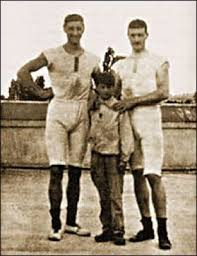

In [12]:
df[df['Age'] == 97]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
257054,128719,John Quincy Adams Ward,M,97.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal


In [13]:
df[df['Weight'] == 214] 

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
23155,12177,"Ricardo Blas, Jr.",M,21.0,183.0,214.0,Guam,GUM,2008 Summer,2008,Summer,Beijing,Judo,Judo Men's Heavyweight,No Medal
23156,12177,"Ricardo Blas, Jr.",M,25.0,183.0,214.0,Guam,GUM,2012 Summer,2012,Summer,London,Judo,Judo Men's Heavyweight,No Medal


In [14]:
appearances = df.groupby('ID')['Name'].count().sort_values(ascending = False)
appearances[:10]

ID
77710     58
106296    39
115354    38
119591    36
44875     32
129196    32
89187     32
119590    32
53240     32
55047     31
Name: Name, dtype: int64

To get an idea of how (un)likely it is that someone went to multiple Olympic games, I created a density plot below:

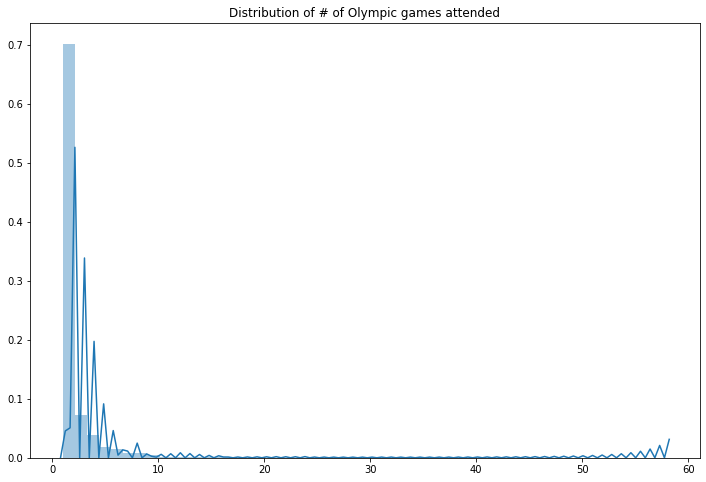

In [24]:
sns.distplot(df.groupby('ID')['Name'].count().values)\
.set_title('Distribution of # of Olympic games attended');

In [69]:
most_appeared_id = appearances.index[0]
df[df['ID'] == most_appeared_id]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
154798,77710,Robert Tait McKenzie,M,44.0,NaN,NaN,Canada,CAN,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Sculpturing,No Medal
154799,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154800,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154801,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154802,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154803,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154804,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154805,77710,Robert Tait McKenzie,M,60.0,NaN,NaN,Canada,CAN,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Sculpturing, Statues",No Medal
154806,77710,Robert Tait McKenzie,M,65.0,NaN,NaN,Canada,CAN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Medals And...",Bronze
154807,77710,Robert Tait McKenzie,M,65.0,NaN,NaN,Canada,CAN,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",No Medal


In [71]:
df[df['ID'] == appearances.index[1]]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
211668,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Individual All-Around,No Medal
211669,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Team All-Around,No Medal
211670,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Horse Vault,No Medal
211671,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Parallel Bars,No Medal
211672,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Horizontal Bar,No Medal
211673,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Rings,No Medal
211674,106296,Heikki Ilmari Savolainen,M,20.0,172.0,64.0,Finland,FIN,1928 Summer,1928,Summer,Amsterdam,Gymnastics,Gymnastics Men's Pommelled Horse,Bronze
211675,106296,Heikki Ilmari Savolainen,M,24.0,172.0,64.0,Finland,FIN,1932 Summer,1932,Summer,Los Angeles,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
211676,106296,Heikki Ilmari Savolainen,M,24.0,172.0,64.0,Finland,FIN,1932 Summer,1932,Summer,Los Angeles,Gymnastics,Gymnastics Men's Team All-Around,Bronze
211677,106296,Heikki Ilmari Savolainen,M,24.0,172.0,64.0,Finland,FIN,1932 Summer,1932,Summer,Los Angeles,Gymnastics,Gymnastics Men's Floor Exercise,No Medal


In [16]:
uncle = df[df['Name'] == 'Arthur Byron MacDonald']

uncle

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
145171,72863,Arthur Byron MacDonald,M,22.0,175.0,61.0,Canada,CAN,1972 Summer,1972,Summer,Munich,Swimming,Swimming Men's 100 metres Butterfly,No Medal
145172,72863,Arthur Byron MacDonald,M,22.0,175.0,61.0,Canada,CAN,1972 Summer,1972,Summer,Munich,Swimming,Swimming Men's 200 metres Butterfly,No Medal


In [17]:
df.groupby('Season').ID.count()

Season
Summer    222552
Winter     48564
Name: ID, dtype: int64

In [18]:
summer_df = df[df['Season'] == 'Summer']
winter_df = df[df['Season'] == 'Winter']

In [19]:
summer_counts = summer_df.groupby('Year').count()
summer_counts.tail()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Season,City,Sport,Event,Medal
Year,,,,,,,,,,,,,,
2000,13821,13821,13821,13820,13698,13695,13821,13821,13821,13821,13821,13821,13821,13821
2004,13443,13443,13443,13443,13407,13406,13443,13443,13443,13443,13443,13443,13443,13443
2008,13602,13602,13602,13600,13451,13443,13602,13602,13602,13602,13602,13602,13602,13602
2012,12920,12920,12920,12920,12752,12560,12920,12920,12920,12920,12920,12920,12920,12920
2016,13688,13688,13688,13688,13512,13465,13688,13688,13688,13688,13688,13688,13688,13688


In [20]:
winter_counts = winter_df.groupby('Year').count()
winter_counts.tail()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Season,City,Sport,Event,Medal
Year,,,,,,,,,,,,,,
1998,3605,3605,3605,3603,3521,3519,3605,3605,3605,3605,3605,3605,3605,3605
2002,4109,4109,4109,4109,4080,4062,4109,4109,4109,4109,4109,4109,4109,4109
2006,4382,4382,4382,4382,4376,4366,4382,4382,4382,4382,4382,4382,4382,4382
2010,4402,4402,4402,4402,4400,4378,4402,4402,4402,4402,4402,4402,4402,4402
2014,4891,4891,4891,4891,4871,4673,4891,4891,4891,4891,4891,4891,4891,4891


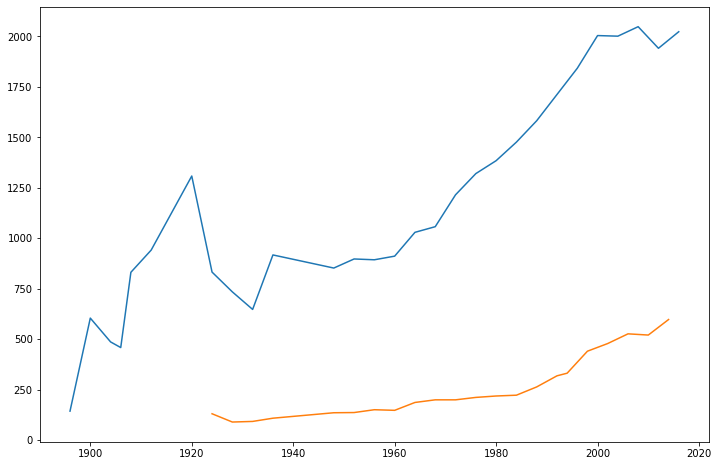

In [25]:
summer_medals = summer_df[summer_df['Medal'] != 'No Medal'][['Year', 'Medal']].groupby('Year').count()
winter_medals = winter_df[winter_df['Medal'] != 'No Medal'][['Year', 'Medal']].groupby('Year').count()

plt.plot(summer_medals);
plt.plot(winter_medals);

## How does the number of athletes change over time?

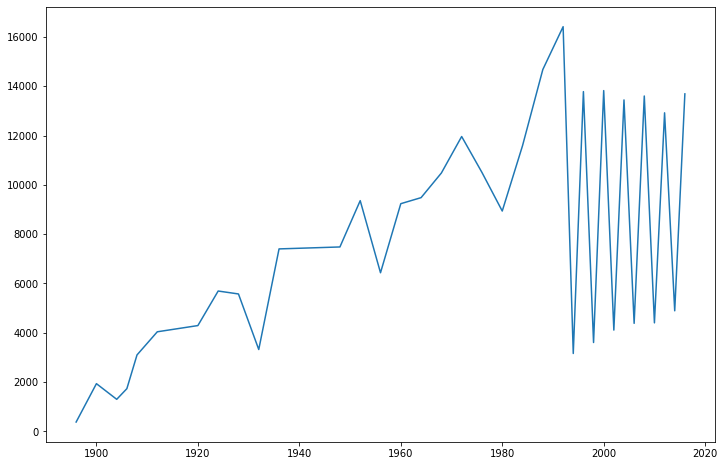

In [47]:
plt.plot(df.groupby('Year').ID.count());

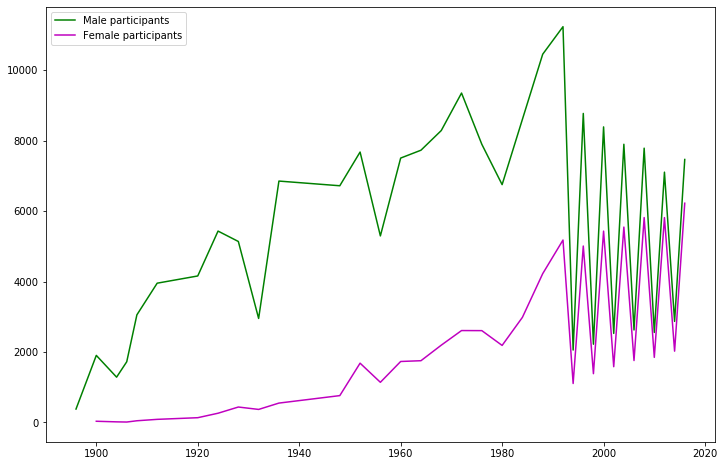

In [54]:
plt.plot(df[df['Sex'] == 'M'].groupby('Year').ID.count(), 'g', label = 'Male participants');
plt.plot(df[df['Sex'] == 'F'].groupby('Year').ID.count(), 'm', label = 'Female participants');
plt.legend(loc = 'upper left');

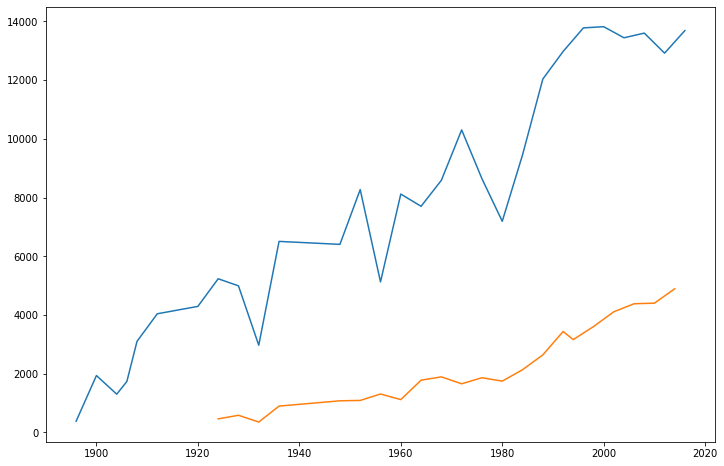

In [32]:
plt.plot(summer_df.groupby('Year').ID.count());
plt.plot(winter_df.groupby('Year').ID.count());

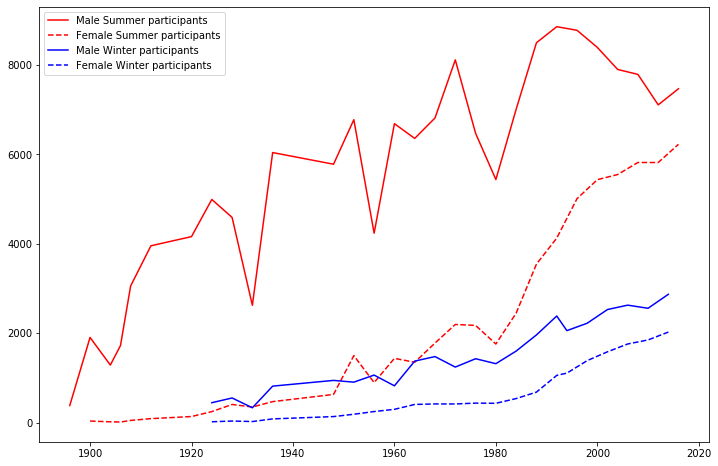

In [45]:
plt.plot(summer_df[summer_df['Sex'] == 'M'].groupby('Year').ID.count(), 'r-', label = "Male Summer participants");
plt.plot(summer_df[summer_df['Sex'] == 'F'].groupby('Year').ID.count(), 'r--', label = "Female Summer participants");
plt.plot(winter_df[winter_df['Sex'] == 'M'].groupby('Year').ID.count(), 'b-', label = "Male Winter participants");
plt.plot(winter_df[winter_df['Sex'] == 'F'].groupby('Year').ID.count(), 'b--', label = "Female Winter participants");
plt.legend(loc = 'upper left');